In [24]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engine = create_engine('postgres:///music')
conn = engine.connect()
engine.table_names()

['reviews', 'artists', 'genres', 'labels', 'years', 'content']

In [3]:
def postgres_to_df(table_name):
    result = conn.execute(f'SELECT * FROM {table_name}')
    columns = [x for x in result.keys()]
    df = pd.DataFrame(result.fetchall(), columns=columns)
    return df

In [5]:
df = postgres_to_df('reviews')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [7]:
df = df[df['pub_year'] >= 2000]

In [8]:
#2000-2009 to 2010-2017
range_1 = df[df['pub_year'] >= 2010] #2010-2017
range_2 = df[df['pub_year'] <= 2009] #2000-2009

In [10]:
range_1['pub_year'].unique(), range_2['pub_year'].unique()

(array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]),
 array([2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000]))

In [11]:
range_1['score'].mean(), range_2['score'].mean()

(7.07467164718643, 6.9509370884409565)

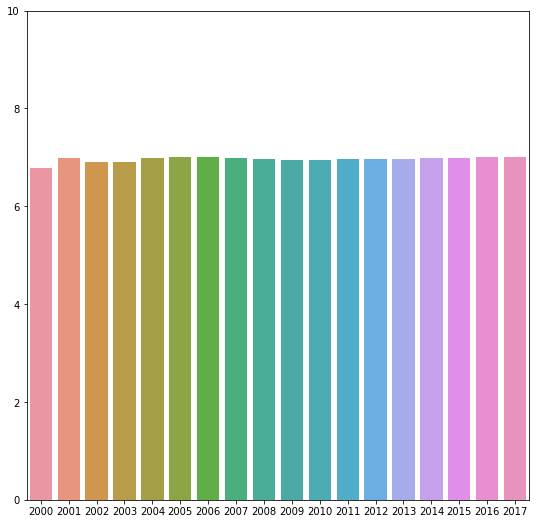

In [26]:
# data is already sorted by pub_date
year_scores = []
years = list(range(2000, 2018))
for year in years:
    year_data = df[df['pub_year'] <= year]
    year_scores.append(year_data['score'].mean())
    
plt.figure(figsize=(9,9))
plt.ylim(0, 10)
sns.barplot(years, year_scores);

[-0.028452045071646337, 0.012478919615331208, -0.0023504444740483077, -0.011673632361121289, -0.0016972948816449396, 0.0007501088175877468, 0.0027086282390018646, 0.0020249947196205875, 0.0025162155746537573, -0.00033101190193551844, -0.0011544291156941888, -0.0006458070244323988, -0.0009965552520969645, -0.0011563978058066748, -0.0012107020491984866, -0.0025611001557510615, -4.774614078550954e-05]


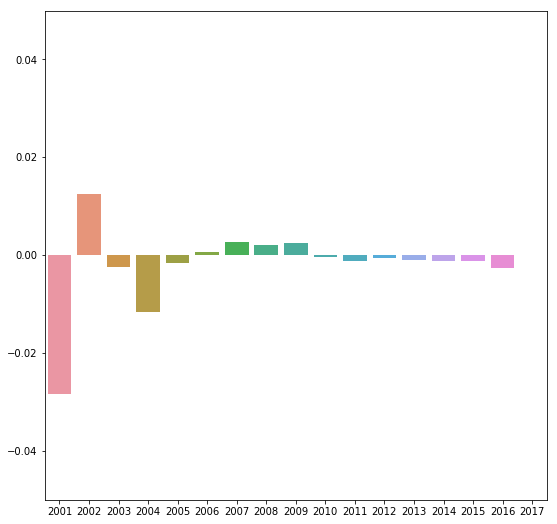

In [35]:
yoy_changes = []
for i in range(len(year_scores) - 1):
    yoy_change = 1 - (year_scores[i+1] / year_scores[i])
    yoy_changes.append(yoy_change)
    
plt.figure(figsize=(9,9))
plt.ylim(-0.05, 0.05)
print(yoy_changes)
sns.barplot(years[1:], yoy_changes);